In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import os
import time
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import argparse
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbing
from mingpt.probe_trainer import Trainer, TrainerConfig
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

### Evaluating linear board probes

In [4]:
layer = 6
model_ckpt = "bias/TLcontrol"

In [5]:
othello = Othello(data_root="othello_synthetic", n_games=10000, deduplicate=False, test_split=0)

# player_types, games = zip(*othello)
train_dataset = CharDataset(othello)

mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbing(mconf, probe_layer=layer)
load_res = model.load_state_dict(torch.load(f"./ckpts/{model_ckpt}.ckpt"))


if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 1.131 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 10000 for training, 0 for validation
Dataset created has 10000 sequences, 61 unique words.


In [6]:
# creating dataset of activations and properties
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []

for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    # truncates game if it is less than 60 moves
    valid_until = tbf.index(-100) if -100 in tbf else 999

    properties = []
    ob = OthelloBoardState()
    for i, move in enumerate(tbf[:valid_until]):
        ob.update([move])

        # flipping states so always from moving player's perspective
        fixed_state = np.array(ob.get_state())
        if ob.get_next_hand_color() == 1:
            fixed_state = 2 - fixed_state
        properties.append(fixed_state)
    property_container.extend(properties)

    # gets activations for each move
    act = model(x.to(device))[0, ...].detach().cpu()  # [block_size, f]
    act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
    act_container.extend(act)

    assert len(act_container) == len(property_container)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-6-9a1f5b2ebd71>:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
<ipython-input-6-9a1f5b2ebd71>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  act = np.array([_[0] for _ in act.split(1, dim=0)[:valid_until]])
100%|██████████| 10000/10000 [01:

In [7]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"{len(act)} pairs loaded...")
        self.act = act
        self.y = y
        # print(np.sum(np.array(y)==0), np.sum(np.array(y)==1), np.sum(np.array(y)==2))
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    def __getitem__(self, idx):
        return self.act[idx], torch.tensor(self.y[idx]).to(torch.long)

probing_dataset = ProbingDataset(act_container, property_container)

probe_loader = DataLoader(probing_dataset, shuffle=False, pin_memory=True, batch_size=128, num_workers=1)

589847 pairs loaded...
y: (array([0., 1., 2.]), array([ 9213753, 17696269, 10840186]))


In [8]:
probe = BatteryProbeClassification(device, probe_class=3, num_task=64)
load_res = probe.load_state_dict(torch.load(f"./ckpts/bias/probes/state/layer{layer}/checkpoint.ckpt"))

probe = probe.to(device)

In [9]:
total_games = 0
total_correct = np.zeros(64)

pbar = tqdm(probe_loader, total=len(probe_loader))
for x, y in pbar:
    x = x.to(device)  # [B, f]
    y = y.to(device)  # [B, #task=64] 

    logits, loss = probe(x, y)
    pred = torch.argmax(logits, dim=2)

    correct = torch.sum(pred == y, dim=0)
    correct = correct.detach().cpu().numpy()
    np.add(total_correct, correct, out=total_correct)

    total_games += x.shape[0]

    pbar.set_description(f"{sum(total_correct) / (total_games * 64):.5f}% correct")

print(total_games)
print(total_correct)

0.97844% correct:   0%|          | 20/4609 [00:00<00:23, 196.70it/s]

0.97951% correct: 100%|██████████| 4609/4609 [00:09<00:00, 490.02it/s]

589847
[576371. 582143. 581946. 582739. 581937. 582377. 582177. 582412. 581503.
 580546. 577970. 576918. 576786. 578917. 581434. 582210. 580729. 578120.
 573501. 569958. 570065. 574714. 579118. 581773. 582683. 577304. 570612.
 564032. 565104. 570389. 577189. 583142. 582634. 577286. 570551. 565025.
 564615. 569964. 577301. 583002. 582970. 578653. 574812. 570665. 570686.
 574330. 578696. 582357. 579852. 580844. 579217. 577245. 577210. 579020.
 580757. 578786. 582935. 579399. 580850. 582543. 582705. 582132. 582042.
 580778.]


<AxesSubplot:>

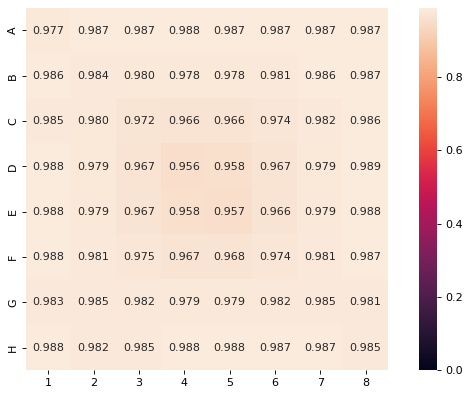

In [10]:
import seaborn as sns

avg = total_correct / total_games
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(avg.reshape(8, 8), vmin=0,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")